## Sampling Pointcloud and extracting features for the sampled data

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
import ipywidgets as widgets

import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.insert(0, parent_dir)

import os
import pickle as pkl
import numpy as np
import pcl
from PIL import Image

from lib.custom_dataloader import Dataset
from torch.utils.data import DataLoader
from lib.seg_utils import dpt_2_cld,draw_p2ds,project_p3d
import matplotlib.pyplot as plt

root_path = "/media/kulunu/Elements SE/Datasets/Nema17_reducer_dataset"

seg_format = '.npy'
img_id_leading_zeros = 0
dpt_format = ".png"
rgb_format = ".png"



/tmp/ipykernel_169285/1554277526.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Sample and Extract features

In [ ]:
dataset = Dataset(root_path, scene_id ='stage_2')
cld_rgb_nrms_path = os.path.join(dataset.dir, 'cld_rgb_nrms')
label_path = os.path.join(dataset.dir, 'labels')

def get_normal( cld):
        cloud = pcl.PointCloud()
        cld = cld.astype(np.float32)
        cloud.from_array(cld)
        ne = cloud.make_NormalEstimation()
        kdtree = cloud.make_kdtree()
        ne.set_SearchMethod(kdtree)
        ne.set_KSearch(50)
        n = ne.compute()
        n = n.to_array()
        return n

rgb_directory = os.path.join(dataset.dir,'rgb')
for filename in os.listdir(rgb_directory):
    name, extension = os.path.splitext(filename)

    idx = name.lstrip('0')
    idx = int(idx) if idx else 0

    K,dpt_K, cam_scale = dataset.get_cam_info(idx)
    
    segmap = np.load(os.path.join(dataset.segmap_dir,str(idx).zfill(img_id_leading_zeros)+'_seg_map'+seg_format))
    segmap_flattened = segmap.flatten()
    
    with Image.open(os.path.join(dataset.dpt_dir,str(idx).zfill(img_id_leading_zeros)+ dpt_format)) as di:
        dpt = np.array(di)
        
    with Image.open(os.path.join(dataset.rgb_dir,str(idx).zfill(img_id_leading_zeros)+ rgb_format)) as ri:
                rgb = np.array(ri)[:, :, :3]
                rgb = np.transpose(rgb, (2, 0, 1))


    #Back-projection util function
    cld, choose = dpt_2_cld(dpt, dpt_K)
 
    # load precalculated segmaps or labels   
    segmap_flattened = segmap_flattened[choose]

    # sample only 12288 points and get the respective cld_rgb_nrm + labels
    rgb_lst = []
    for ic in range(rgb.shape[0]):
        rgb_lst.append(
            rgb[ic].flatten()[choose].astype(np.float32)
        )
     
    rgb_pt = np.transpose(np.array(rgb_lst), (1, 0)).copy()
    
    
    choose = np.array([choose], dtype= np.uint32)
    choose_2 = np.array([i for i in range(len(choose[0, :]))])
    
    
    if len(choose_2) < 400:
        print("not_enough points")
        
    if len(choose_2) > dataset.n_sample_points:
        c_mask = np.zeros(len(choose_2), dtype=int)
        c_mask[:dataset.n_sample_points] = 1
        np.random.shuffle(c_mask)
        choose_2 = choose_2[c_mask.nonzero()]
    else:
        choose_2 = np.pad(choose_2, (0, dataset.n_sample_points-len(choose_2)), 'wrap')
    
    # select only the sampled indexes    
    rgb_pt = rgb_pt[choose_2,:]  
    cld = cld[choose_2, :]

    normals = get_normal(cld)[:,:3]
    normals[np.isnan(normals)] = 0.

    cld_rgb_nrm = np.concatenate((cld, rgb_pt, normals), axis=1)
    
    # labels are the corresponding per sampled point, segmap is the perpoint labels for all points
    labels = segmap_flattened[choose_2].astype(np.int32)
    
    #save the choose with each label 
    choose = np.squeeze(choose[:, choose_2])
    arr = [labels,choose]

   
    
    if not os.path.exists(cld_rgb_nrms_path):
        os.makedirs(cld_rgb_nrms_path)
    if not os.path.exists(label_path):
            os.makedirs(label_path)
    if not os.path.exists(os.path.join(cld_rgb_nrms_path,str(idx)+'.pkl')):
        print('Writing file '+str(idx)) 
        with open(os.path.join(cld_rgb_nrms_path,str(idx)+'.pkl'), 'wb') as file:
            pkl.dump(cld_rgb_nrm,file)
        np.save(os.path.join(label_path,str(idx)+'.npy'), arr) 

Writing file 0
Writing file 1
Writing file 10
Writing file 100
Writing file 101
Writing file 102
Writing file 103
Writing file 104
Writing file 105
Writing file 106
Writing file 107
Writing file 108
Writing file 109
Writing file 11
Writing file 110
Writing file 111
Writing file 112
Writing file 113
Writing file 114
Writing file 115
Writing file 116
Writing file 117
Writing file 118
Writing file 119
Writing file 12
Writing file 300
Writing file 301
Writing file 302
Writing file 303
Writing file 304
Writing file 305
Writing file 306
Writing file 307
Writing file 308
Writing file 309
Writing file 31
Writing file 310
Writing file 311
Writing file 312
Writing file 313
Writing file 314
Writing file 315
Writing file 316
Writing file 317
Writing file 318
Writing file 319
Writing file 32
Writing file 320
Writing file 321
Writing file 322
Writing file 323
Writing file 189
Writing file 19
Writing file 190
Writing file 191
Writing file 192
Writing file 193
Writing file 194
Writing file 195
Writing

### Always visualize data to confrim

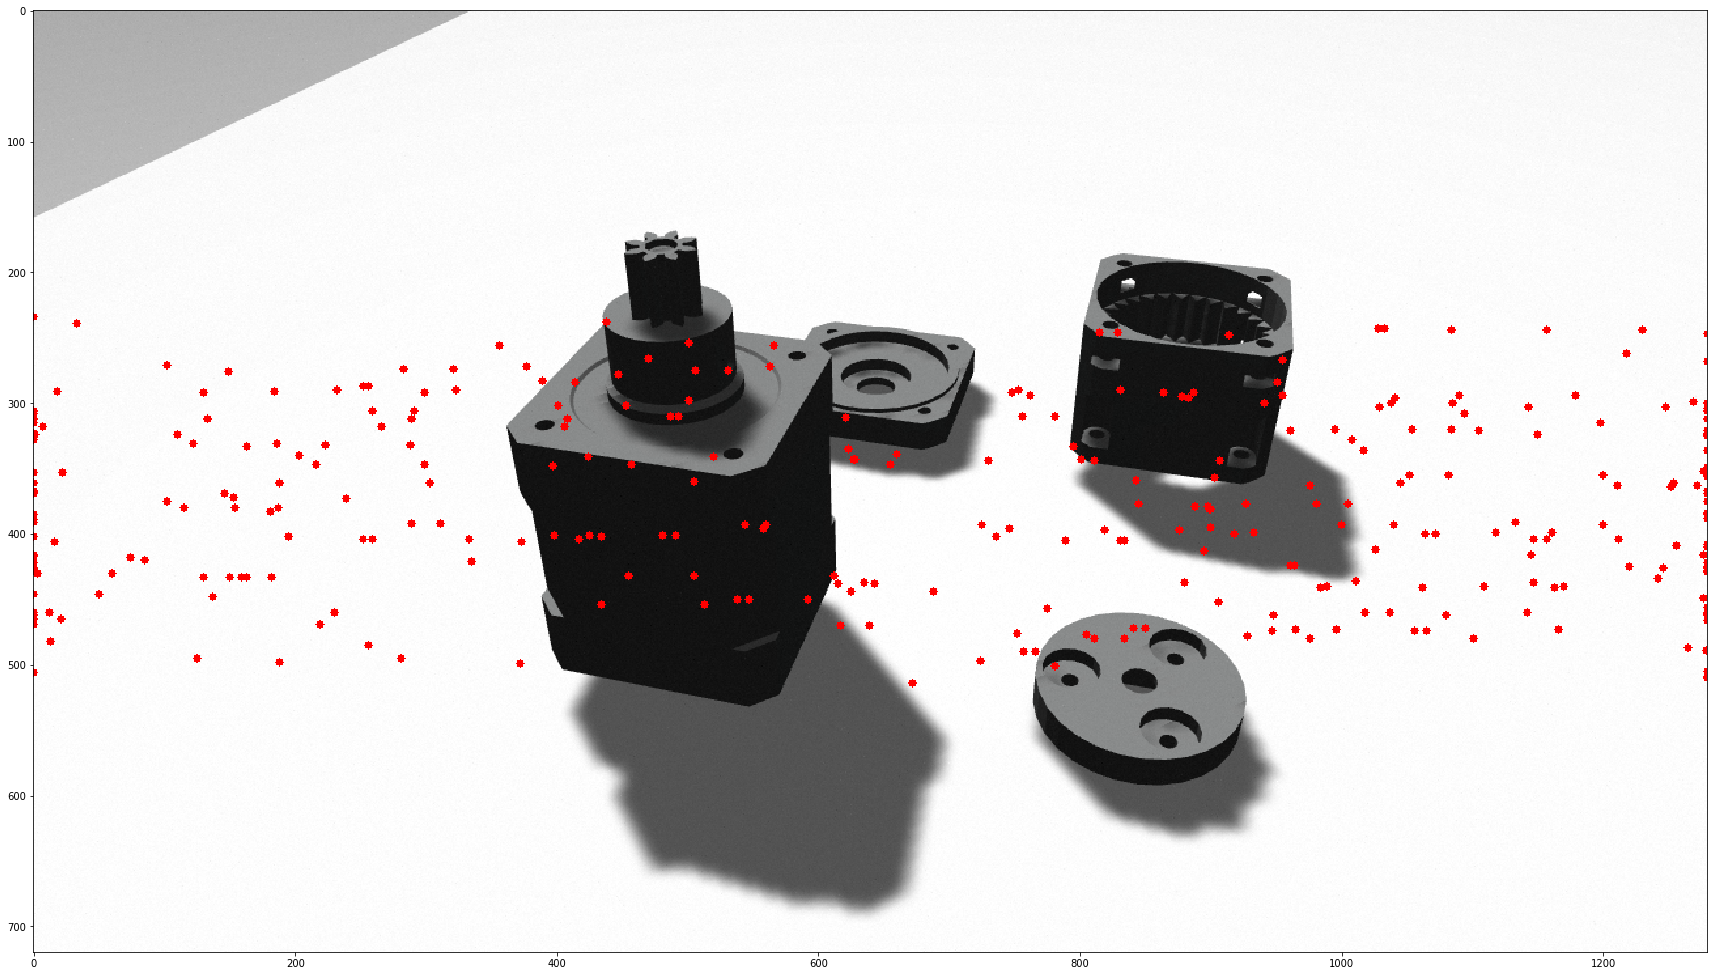

In [10]:
# TODO : Visualize random data, 4 tiles
idx = 7
data_torch = dataset.get_item(idx=idx)

cu_dt = [item.contiguous().to("cuda", non_blocking=True) for item in data_torch]    
labels, cld_rgb_nrm, choose, rgb  = cu_dt

pcld = cld_rgb_nrm.squeeze().cpu().numpy()[:,0:3]
labels = labels.squeeze().cpu().numpy()
rgb = rgb.cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()

K,dpt_K, cam_scale = dataset.get_cam_info(idx=idx)

color = (255,0,0)
p2ds = project_p3d(pcld[labels == 1], cam_scale, K)
rgb = draw_p2ds(rgb, p2ds,color,3)

plt.figure(figsize=(30,30))
plt.imshow(np.asarray(rgb,np.int32),interpolation='none')
plt.show()  

In [ ]:
# TODO : The processing takes longer.
num_images = 4
rows = 2
cols = 2
fig = plt.figure(figsize=(15,12))

dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
K,dpt_K, cam_scale = dataset.get_cam_info(idx=0)
labels, cld_rgb_nrm, choose, rgb = next(iter(dataloader))

colors = [
    (128, 128, 128),  # Grey
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Yellow
    (255, 165, 0)     # Orange
]

for idx in range(num_images):
    
    pcld = cld_rgb_nrm[idx].squeeze().cpu().numpy()[:,0:3].copy()
    label = labels[idx].squeeze().cpu().numpy().copy()
    rgb_ = rgb[idx].cpu().numpy().transpose(1, 2, 0)[...,::-1].copy()

    for i in range(0, len(np.unique(labels))):
         p2ds = project_p3d(pcld[label == i], cam_scale, K)
         rgb_ = draw_p2ds(rgb_, p2ds,colors[i],3)

    ax = fig.add_subplot(rows, cols, idx + 1)
    plt.imshow(np.asarray(rgb_,np.int32),interpolation='none')
    ax.set_title(f"Image {idx + 1}")

plt.show()
    

In [ ]:
# TODO Faster Image drawing with GPU ( Incomplete)
 
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def draw_p2ds( img, p2ds, color, rad):
        h, w = img.shape[0], img.shape[1]

        for pt_2d in p2ds:
            pt_2d[0] = np.clip(pt_2d[0], 0, w)
            pt_2d[1] = np.clip(pt_2d[1], 0, h)

            if p2ds.shape[1]>2:
                img = cv2.circle(
                    cv2.UMat(img), (pt_2d[0], pt_2d[1]), rad, (int(pt_2d[2]), int(pt_2d[3]), int(pt_2d[4])) , -1
                )
            else:
                img = cv2.circle(
                    cv2.UMat(img), (pt_2d[0], pt_2d[1]), rad, color, -1
                )
            '''
            img = cv2.circle(
                img, (pt_2d[0], pt_2d[1]), rad, color, -1
            )'''
          
        return img.get()

def project_p3d(p3d, cam_scale, K):
    device = p3d.device
    
    if p3d.size(1) < 4:
        p3d = p3d * cam_scale
        p2d = torch.matmul(p3d, K.t())
        p2d_3 = p2d[:, 2]
        p2d_3[p2d_3 < 1e-8] = 1.0
        p2d[:, 2] = p2d_3
        p2d = torch.round((p2d[:, :2] / p2d[:, 2:])).to(torch.int32)
        return p2d
    else:
        p3d = p3d * cam_scale
        p2d = torch.matmul(p3d[:, :3], K.t())
        p2d_3 = p2d[:, 2]
        mask = p2d_3 < 1e-8
        if torch.any(mask):
            p2d_rgbs = p3d[mask, 3:6]
            p2d_3[mask] = 1.0
        else:
            p2d_rgbs = p3d[:, 3:6]
        p2d[:, 2] = p2d_3
        p2d = torch.round((p2d[:, :2] / p2d[:, 2:])).to(torch.int32)
        
        return p2d

# Assuming the dataset, cam_scale, and K are already defined
num_images = 4
rows = 2
cols = 2
fig = plt.figure(figsize=(15,12))

dataloader = DataLoader(dataset, batch_size=num_images, shuffle=True)
K, dpt_K, cam_scale = dataset.get_cam_info(idx=0)
labels, cld_rgb_nrm, choose, rgb = next(iter(dataloader))


colors = torch.tensor([
    [128, 128, 128],  # Grey
    [255, 0, 0],      # Red
    [0, 255, 0],      # Green
    [0, 0, 255],      # Blue
    [255, 255, 0],    # Yellow
    [255, 165, 0]     # Orange
], dtype=torch.uint8)

device = next(iter(cld_rgb_nrm)).device

for idx in range(num_images):
    pcld = cld_rgb_nrm[idx].squeeze()[:, 0:3].clone()
    label = labels[idx].squeeze().clone()  # Remove .numpy() call
    #rgb_ = rgb[idx].transpose(1, 2, 0)[...,::-1].clone()  # Remove .numpy() call
    #rgb_ = torch.transpose(rgb[idx],(1, 2, 0))[...,::-1].clone()
    rgb_ = rgb[idx].permute(1, 2, 0).clone().to(device)[:, :, [2, 1, 0]]

    for i in range(len(torch.unique(labels))):
        p2ds = project_p3d(pcld[label == i].to(device),float(cam_scale), torch.tensor(K, dtype=torch.float32).to(device))
        rgb_ = draw_p2ds(rgb_, p2ds.cpu().numpy(), colors[i].tolist().cpu().numpy(), 3)

    ax = fig.add_subplot(rows, cols, idx + 1)
    plt.imshow(rgb_, interpolation='none')
    ax.set_title(f"Image {idx + 1}")

plt.show()

In [ ]:
# TODO : Create a visualization gif
